In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.cluster import KMeans
import pingouin as pg
import bct
from surfplot import Plot
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.mesh_io import read_surface
from surfplot.utils import add_fslr_medial_wall
from joblib import Parallel, delayed
from nilearn.connectome import ConnectivityMeasure
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.base import sqrtm, logm, expm, invsqrtm
import natsort
import nibabel as nib
from nilearn.plotting import cm
import cmasher as cmr
import glob
import warnings
warnings.filterwarnings('ignore')

/Users/keannarowchan/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/keannarowchan/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#config.py

In [3]:
pjoin = os.path.join

config_path = '/Users/keannarowchan/Desktop/statistical-manifolds/'
resources = pjoin(config_path, 'resources')

atlas = pjoin(resources, 'atlas/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii')
adjacency = pjoin(resources, 'atlas/Schaefer2018_1000Parcels_7Networks_adjacency.tsv')        

data_dir = pjoin(config_path, 'data')
connect = pjoin(data_dir, 'connectivity')
gradients = pjoin(data_dir, 'pca-gradients-centered')
tseries = pjoin(data_dir, 'timeseries/')

results = pjoin(config_path, f'results/')
figures = pjoin(config_path, f'figures/')

In [4]:
#utils.py

In [5]:
import os
import glob
import subprocess
from datetime import datetime
import natsort
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nib
from brainspace.mesh.mesh_io import read_surface
import bct
from neuromaps import images


pjoin = os.path.join

def get_files(pattern, force_list=False):
    if isinstance(pattern, list):
        pattern = pjoin(*pattern)
    files = natsort.natsorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError('Pattern could not detect file(s)')

    if (not force_list) & (len(files) == 1):
        return files[0] 
    else:
        return files


def check_img(img):
    return nib.load(img) if isinstance(img, str) else img


def display(msg):
    t = datetime.now().strftime("%H:%M:%S")
    print(f'[{t}] {msg}')


def parse_roi_names(x, col='roi'):
    roi_cols = ['hemi', 'network', 'name']
    x[roi_cols] = x[col].str.split('_', n=3, expand=True).iloc[:, 1:]
    return x


def load_gradients(fname, k=None):
    df = pd.read_table(fname, index_col=0)
    if k is not None:
        df = df.iloc[:, :k]
        
    df = df.reset_index().rename(columns={'index': 'roi'})
    df = parse_roi_names(df)
    return df


def load_table(fname):
    return pd.read_table(fname, index_col=0)


def get_surfaces(style='inflated', load=True):
    surf_path = os.path.join(resources, 'surfaces')
    surfaces = get_files([surf_path, f'*.{style}_*'])
    
    if load:
        surfs = [read_surface(i) for i in surfaces]
        return dict(zip(['lh', 'rh'], surfs))
    else:
        return surfaces


def schaefer1000_roi_ix():
    x = np.arange(1000) + 1
    return x[~np.isin(x, [533, 903])]


def fdr_correct(x, colname='p-unc'):
    corrected = pg.multicomp(x[colname].values, method='fdr_bh')
    x[['sig_corrected', 'p_fdr']] = np.array(corrected).T
    return x


def parcellation_adjacency(dlabel, lh_surf, rh_surf, min_vertices=1):
    tmp = 'adjacency.pconn.nii'
    cmd = f"wb_command -cifti-label-adjacency {dlabel} {tmp} " \
          f"-left-surface {lh_surf} -right-surface {rh_surf}"
    subprocess.run(cmd.split())
    
    adj = (nib.load(tmp).get_fdata() >= min_vertices).astype(float)
    os.remove(tmp)

    assert np.array_equal(adj, adj.T)
    remove_ix = np.where(np.sum(np.abs(adj), axis=1) == 0)[0]
    if len(remove_ix) > 0:
        adj = np.delete(adj, remove_ix, axis=0)
        adj = np.delete(adj, remove_ix, axis=1)
    return adj


def get_clusters(data, adjacency, sort=True, yuh=False):

    ix = data.query("sig_corrected == 1")['roi_ix'].values
    
    adjacency.columns = adjacency.columns.astype(int)
    x = adjacency.loc[ix, ix].values
    assignments, sizes = bct.get_components(x)

    cluster_table = pd.DataFrame({
        'cluster': np.arange(len(sizes)) + 1, 
        'size': sizes
    })

    res = data.copy()
    res.index = res['roi_ix'].values
    res['cluster'] = 0
    res.loc[ix, 'cluster'] = assignments
    res = res.merge(cluster_table, on='cluster', how='left')
    res['size'] = np.nan_to_num(res['size'])

    if sort:
        labels = res.sort_values('size', ascending=False)['cluster'].unique()
        new_labels = np.concatenate([np.arange(len(labels[:-1])) + 1, [0]])
        relabel_map = dict(zip(labels, new_labels))
        res['cluster'] = res['cluster'].apply(lambda x: relabel_map[x])

    return res


def test_regions(data, method='anova', p_thresh=.05):

    test = dict(anova=pg.rm_anova, ttest=pg.pairwise_ttests)
    if method not in test.keys():
        raise ValueError(f"method must be one of {list(test.keys())}")
    
    test_data = data[['sub', 'roi', 'roi_ix', 'epoch', 'distance']]

    kwargs = dict(correction=True) if method == 'anova' else {}
    res = test_data.groupby(['roi', 'roi_ix'], sort=False) \
                   .apply(test[method], dv='distance', within='epoch', 
                          subject='sub', **kwargs) \
                   .reset_index() \
                   .drop('level_2', axis=1)
    res['sig'] = (res['p-unc'] < p_thresh).astype(float)
    res = fdr_correct(res)
    
    adj = pd.read_table(adjacency, index_col=0)
    if method == 'ttest':
        res = res.groupby(['A', 'B'], sort=False) \
                 .apply(get_clusters, adj) \
                 .reset_index(drop=True)
    else:
        res = get_clusters(res, adj)
    return res


def _cornblath(data, atlas='fsaverage', density='10k', parcellation=None, n_perm=1000, seed=None, spins=None, surfaces=None):
 
    from neuromaps.datasets import fetch_atlas
    from neuromaps.nulls.spins import spin_data

    if parcellation is None:
        raise ValueError('Cannot use `cornblath()` null method without '
                         'specifying a parcellation. Use `alexander_bloch() '
                         'instead if working with unparcellated data.')
    y = np.asarray(data)
    if surfaces is None:
        surfaces = fetch_atlas(atlas, density)['sphere']
    nulls = spin_data(y, surfaces, parcellation, n_rotate=n_perm, spins=spins, seed=seed)
    return nulls


def permute_map(data, parc, n_perm=1000):
    lh_gii, rh_gii = images.dlabel_to_gifti(parc)
    relabeled_parc = images.relabel_gifti((lh_gii, rh_gii))

    spins = _cornblath(data, atlas='fslr', density='32k', parcellation=relabeled_parc, n_perm=n_perm, seed=1234)
    return spins

In [6]:
#connectivity.py

In [7]:
def _baseline_window_length():
    return 203

def do_not_drop_nontask_samps(x):
    return x


def _split_by_earlyandlate_learning(x):
    window_length = _baseline_window_length()

    baseline = x[:window_length]
    early = x[window_length: window_length*2]
    late = x[window_length*6: window_length*7]
    return [baseline, early, late]


def _split_by_learning(x):
    window_length = _baseline_window_length()

    baseline = x[:window_length]
    learning = x[window_length:]
    return [baseline, learning]


def compute_connectivity(timeseries, output_dir, float_fmt='%1.8f', split='earlyandlate'):
    
    fname = os.path.split(timeseries)[1]
    display(fname)
    data = pd.read_table(timeseries)
    tseries = data.values
    regions = data.columns

    # handle different scan types
    if 'full' in fname:
        tseries = do_not_drop_nontask_samps(tseries)
        
        if split == 'learning':
            dataset = _split_by_learning(tseries)
        elif split == 'earlyandlate':
            dataset = _split_by_earlyandlate_learning(tseries)
        else:
            dataset = [tseries]

    elif 'washout' in fname:
        dataset = [do_not_drop_nontask_samps(tseries)]
    else:
        dataset = [tseries]

    conn = ConnectivityMeasure(kind='covariance')
    connectivities = conn.fit_transform(dataset)

    output_dir = pjoin(output_dir, fname[:6])
    os.makedirs(output_dir, exist_ok=True)
    
    cmat_name = fname.split('_space')[0] + '_cmat'
    n_matrices = len(connectivities)
    if n_matrices == 2:
        suffix = ['_base', '_learn']
    elif n_matrices == 3:
        suffix = ['_base', '_early', '_late']
    else:
        suffix = ['']
        
    for s, cmat in zip(suffix, connectivities):
        out = pjoin(output_dir, cmat_name + s + '.tsv')
        out_cmat = pd.DataFrame(cmat, index=regions, columns=regions)
        out_cmat = out_cmat.drop(['Unnamed: 0'], axis=1)
        out_cmat = out_cmat.drop(['Unnamed: 0'], axis=0)
        out_cmat.to_csv(out, float_format=float_fmt, sep='\t')


def connectivity_analysis(input_data, out_dir, njobs=45):
    os.makedirs(out_dir, exist_ok=True)
    timeseries = get_files(input_data + '/*full*.tsv')
    
    for ts in timeseries:
        compute_connectivity(ts, out_dir)

def _to_tangent(s, mean):
    p = sqrtm(mean)
    p_inv = invsqrtm(mean)
    return p @ logm(p_inv @ s @ p_inv) @ p 
    

def _gl_transport(t, sub_mean, grand_mean):
    g = sqrtm(grand_mean) @ invsqrtm(sub_mean)
    return g @ t @ g.T


def _from_tangent(t, grand_mean):
    p = sqrtm(grand_mean)
    p_inv = invsqrtm(grand_mean)
    return p @ expm(p_inv @ t @ p_inv) @ p 


def center_cmat(c, sub_mean, grand_mean):
    t = _to_tangent(c, sub_mean)
    tc = _gl_transport(t, sub_mean, grand_mean)
    return _from_tangent(tc, grand_mean)


def center_subject(sub_cmats, grand_mean):
    sub_mean = mean_riemann(sub_cmats)
    return np.array([center_cmat(c, sub_mean, grand_mean) for c in sub_cmats])


def _read_and_stack_cmats(x):
    arr = np.array([pd.read_table(i, index_col=0).values for i in x])
    labels = pd.read_table(x[0], index_col=0).columns
    return arr, labels


def center_matrices(data_dir, float_fmt='%1.8f'):
    cmats = get_files([data_dir, '*/*.tsv'])
    out_dir = data_dir + '-centered'
    os.makedirs(out_dir, exist_ok=True)
    
    all_cmats, roi_labels = _read_and_stack_cmats(cmats)
    display('Computing grand mean')
    grand_mean = mean_riemann(all_cmats)

    # save grand mean
    df = pd.DataFrame(grand_mean, index=roi_labels, columns=roi_labels) 
    df.to_csv(pjoin(out_dir, 'grand_mean.tsv'), sep='\t', float_format=float_fmt)

    subs = np.unique([os.path.basename(x)[:6] for x in cmats])
    for s in subs:
        display(s)
        sub_files = [i for i in cmats if s in i]
        sub_cmats, _ = _read_and_stack_cmats(sub_files)
        centered_cmats = center_subject(sub_cmats, grand_mean)

        for i, fname in enumerate(sub_files):
            df = pd.DataFrame(centered_cmats[i], index=roi_labels, columns=roi_labels) 
            out_name = fname.replace(data_dir, out_dir)
            os.makedirs(os.path.split(out_name)[0], exist_ok=True)
            df.to_csv(out_name, sep='\t', float_format=float_fmt)

#connectivity_analysis(tseries, connect)
#center_matrices(connect)

In [ ]:
#connectivity matrices

In [22]:
cd = pjoin(connect + '/')

def all_participant_matrix(connectivity_directory):
    out_dir = pjoin(figures, 'all_sub_connectivity')
    base_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'base')
    early_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'early')
    late_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'late')
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(base_out_dir, exist_ok=True)
    os.makedirs(early_out_dir, exist_ok=True)
    os.makedirs(late_out_dir, exist_ok=True)
    
    subid = ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06',  'sub-07',  'sub-10',  'sub-11',  'sub-12',  'sub-13',   'sub-14',   'sub-15',   'sub-16',  'sub-17',  'sub-18',  'sub-19',  'sub-20',  'sub-21',  'sub-22',  'sub-23',  'sub-24',  'sub-25',  'sub-26',  'sub-27',  'sub-28',  'sub-29',  'sub-30',  'sub-31',  'sub-32',  'sub-33',  'sub-34',  'sub-35',  'sub-36',  'sub-37']

    all_subjects_cmat_data = []
    for sub in subid:
        cmat_data = get_files(connectivity_directory + sub + "/" + '*full*.tsv') 
        for i in cmat_data:
            all_subjects_cmat_data.append(i)
    global early_cmats
    base_cmats = []
    early_cmats = []
    late_cmats = []
    for i in all_subjects_cmat_data:
        print(i)

In [23]:
all_participant_matrix(cd) -centered

/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-01/sub-01_stat-full-task_cmat_base.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-01/sub-01_stat-full-task_cmat_early.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-01/sub-01_stat-full-task_cmat_late.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-02/sub-02_stat-full-task_cmat_base.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-02/sub-02_stat-full-task_cmat_early.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-02/sub-02_stat-full-task_cmat_late.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-03/sub-03_stat-full-task_cmat_base.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-03/sub-03_stat-full-task_cmat_early.tsv
/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity/sub-03/sub-03_stat-full-task_cma

In [ ]:
cd = pjoin(connect + '/')

def all_participant_matrix(connectivity_directory):
    out_dir = pjoin(figures, 'all_sub_connectivity')
    base_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'base')
    early_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'early')
    late_out_dir = pjoin(data_dir, 'all_sub_connectivity', 'late')
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(base_out_dir, exist_ok=True)
    os.makedirs(early_out_dir, exist_ok=True)
    os.makedirs(late_out_dir, exist_ok=True)
    
    subid = ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06',  'sub-07',  'sub-10',  'sub-11',  'sub-12',  'sub-13',   'sub-14',   'sub-15',   'sub-16',  'sub-17',  'sub-18',  'sub-19',  'sub-20',  'sub-21',  'sub-22',  'sub-23',  'sub-24',  'sub-25',  'sub-26',  'sub-27',  'sub-28',  'sub-29',  'sub-30',  'sub-31',  'sub-32',  'sub-33',  'sub-34',  'sub-35',  'sub-36',  'sub-37']

    all_subjects_cmat_data = []
    for sub in subid:
        cmat_data = get_files(connectivity_directory + sub + "/" + '*full*.tsv') 
        for i in cmat_data:
            all_subjects_cmat_data.append(i)
    global early_cmats
    base_cmats = []
    early_cmats = []
    late_cmats = []
    for i in all_subjects_cmat_data:
        if i[-9:] == "_base.tsv":
            df = pd.read_table(i)
            df = df.drop([0], axis=0)
            df = df.drop(['Unnamed: 0'], axis=1)
            array = df.to_numpy()
            base_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/base/{i[114:120]}_connectivity.png")
        elif i[-9:] == "early.tsv":
            df = pd.read_table(i)
            df = df.drop([0], axis=0)
            df = df.drop(['Unnamed: 0'], axis=1)
            array = df.to_numpy()
            early_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/early/{i[114:120]}_connectivity.png")
        elif i[-9:] == "_late.tsv":
            df = pd.read_table(i)
            df = df.drop([0], axis=0)
            df = df.drop(['Unnamed: 0'], axis=1)
            array = df.to_numpy()
            late_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/late/{i[114:120]}_connectivity.png")
all_participant_matrix(cd)

mean_base_connectivity = np.mean([base_cmats[0], base_cmats[1], base_cmats[3], base_cmats[4], base_cmats[5], base_cmats[6], base_cmats[7], base_cmats[8], base_cmats[9], base_cmats[10], base_cmats[11], base_cmats[12], base_cmats[13], base_cmats[14], base_cmats[15], base_cmats[16], base_cmats[17], base_cmats[18], base_cmats[19], base_cmats[20], base_cmats[21], base_cmats[22], base_cmats[23], base_cmats[24], base_cmats[25], base_cmats[26], base_cmats[27], base_cmats[28], base_cmats[29], base_cmats[30], base_cmats[31], base_cmats[32], base_cmats[33]], axis=0)   
early_base_connectivity = np.mean([early_cmats[0], early_cmats[1], early_cmats[3], early_cmats[4], early_cmats[5], early_cmats[6], early_cmats[7], early_cmats[8], early_cmats[9], early_cmats[10], early_cmats[11], early_cmats[12], early_cmats[13], early_cmats[14], early_cmats[15], early_cmats[16], early_cmats[17], early_cmats[18], early_cmats[19], early_cmats[20], early_cmats[21], early_cmats[22], early_cmats[23], early_cmats[24], early_cmats[25], early_cmats[26], early_cmats[27], early_cmats[28], early_cmats[29], early_cmats[30], early_cmats[31], early_cmats[32], early_cmats[33]], axis=0)   
late_base_connectivity = np.mean([late_cmats[0], late_cmats[1], late_cmats[3], late_cmats[4], late_cmats[5], late_cmats[6], late_cmats[7], late_cmats[8], late_cmats[9], late_cmats[10], late_cmats[11], late_cmats[12], late_cmats[13], late_cmats[14], late_cmats[15], late_cmats[16], late_cmats[17], late_cmats[18], late_cmats[19], late_cmats[20], late_cmats[21], late_cmats[22], late_cmats[23], late_cmats[24], late_cmats[25], late_cmats[26], late_cmats[27], late_cmats[28], late_cmats[29], late_cmats[30], late_cmats[31], late_cmats[32], late_cmats[33]], axis=0)   

ax = sns.heatmap(mean_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/base/mean_connectivity.png")

ax = sns.heatmap(early_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/early/mean_connectivity.png")

ax = sns.heatmap(late_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity/early/mean_connectivity.png")

In [ ]:
#connectivity matrices centered

In [ ]:
cd = pjoin(connect + '-centered/')

def all_participant_matrix(connectivity_directory):
    out_dir = pjoin(figures, 'all_sub_connectivity-centered')
    base_out_dir = pjoin(figures, 'all_sub_connectivity-centered', 'base')
    early_out_dir = pjoin(figures, 'all_sub_connectivity-centered', 'early')
    late_out_dir = pjoin(figures, 'all_sub_connectivity-centered', 'late')
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(figures, exist_ok=True)
    os.makedirs(figures, exist_ok=True)
    os.makedirs(figures, exist_ok=True)
    
    subid = ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06',  'sub-07',  'sub-10',  'sub-11',  'sub-12',  'sub-13',   'sub-14',   'sub-15',   'sub-16',  'sub-17',  'sub-18',  'sub-19',  'sub-20',  'sub-21',  'sub-22',  'sub-23',  'sub-24',  'sub-25',  'sub-26',  'sub-27',  'sub-28',  'sub-29',  'sub-30',  'sub-31',  'sub-32',  'sub-33',  'sub-34',  'sub-35',  'sub-36',  'sub-37']

    all_subjects_cmat_data = []
    for sub in subid:
        cmat_data = get_files(connectivity_directory + sub + "/" + '*full*.tsv') 
        for i in cmat_data:
            all_subjects_cmat_data.append(i)
    global early_cmats
    base_cmats = []
    early_cmats = []
    late_cmats = []
    for i in all_subjects_cmat_data:
        if i[-9:] == "_base.tsv":
            df = pd.read_table(i)
            
            df = df.drop(['Unnamed: 0'], axis=1)
            df = df.drop([0], axis=0)
            array = df.to_numpy()
            base_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/base/{i[114:120]}_connectivity.png")
        elif i[-9:] == "early.tsv":
            df = pd.read_table(i)
            df = df.drop(['Unnamed: 0'], axis=1)
            df = df.drop([0], axis=0)
            array = df.to_numpy()
            early_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/early/{i[114:120]}_connectivity.png")
        elif i[-9:] == "_late.tsv":
            df = pd.read_table(i)
            df = df.drop(['Unnamed: 0'], axis=1)
            df = df.drop([0], axis=0)
            array = df.to_numpy()
            late_cmats.append(array)
            mat, labels = df, df.columns.values.tolist()
            ax = sns.heatmap(mat, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200), cbar=False)
            plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/late/{i[114:120]}_connectivity.png")
all_participant_matrix(cd)

mean_base_connectivity = np.mean([base_cmats[0], base_cmats[1], base_cmats[3], base_cmats[4], base_cmats[5], base_cmats[6], base_cmats[7], base_cmats[8], base_cmats[9], base_cmats[10], base_cmats[11], base_cmats[12], base_cmats[13], base_cmats[14], base_cmats[15], base_cmats[16], base_cmats[17], base_cmats[18], base_cmats[19], base_cmats[20], base_cmats[21], base_cmats[22], base_cmats[23], base_cmats[24], base_cmats[25], base_cmats[26], base_cmats[27], base_cmats[28], base_cmats[29], base_cmats[30], base_cmats[31], base_cmats[32], base_cmats[33]], axis=0)   
early_base_connectivity = np.mean([early_cmats[0], early_cmats[1], early_cmats[3], early_cmats[4], early_cmats[5], early_cmats[6], early_cmats[7], early_cmats[8], early_cmats[9], early_cmats[10], early_cmats[11], early_cmats[12], early_cmats[13], early_cmats[14], early_cmats[15], early_cmats[16], early_cmats[17], early_cmats[18], early_cmats[19], early_cmats[20], early_cmats[21], early_cmats[22], early_cmats[23], early_cmats[24], early_cmats[25], early_cmats[26], early_cmats[27], early_cmats[28], early_cmats[29], early_cmats[30], early_cmats[31], early_cmats[32], early_cmats[33]], axis=0)   
late_base_connectivity = np.mean([late_cmats[0], late_cmats[1], late_cmats[3], late_cmats[4], late_cmats[5], late_cmats[6], late_cmats[7], late_cmats[8], late_cmats[9], late_cmats[10], late_cmats[11], late_cmats[12], late_cmats[13], late_cmats[14], late_cmats[15], late_cmats[16], late_cmats[17], late_cmats[18], late_cmats[19], late_cmats[20], late_cmats[21], late_cmats[22], late_cmats[23], late_cmats[24], late_cmats[25], late_cmats[26], late_cmats[27], late_cmats[28], late_cmats[29], late_cmats[30], late_cmats[31], late_cmats[32], late_cmats[33]], axis=0)   

ax = sns.heatmap(mean_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/base/mean_connectivity.png")

ax = sns.heatmap(early_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/early/mean_connectivity.png")

ax = sns.heatmap(late_base_connectivity, square=True, vmin=-.8, vmax=.8, center=0, cmap=sns.diverging_palette(220, 20, n=200))
plt.savefig(f"/Users/keannarowchan/Desktop/statistical-manifolds/figures/all_sub_connectivity-centered/early/mean_connectivity.png")

In [8]:
#gradients

In [13]:
import os
import re
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from brainspace.gradient import GradientMaps
from pyriemann.utils.mean import mean_riemann

def _pca_gradients(x, ref=None):
    """PCA model"""
    alignment = None if ref is None else 'procrustes'
    gm = GradientMaps(n_components=None, approach='pca', kernel='cosine', alignment=alignment)
    gm.fit(x, reference=ref)
    return gm

def _dm_gradients(x, ref=None):
    """Diffusion embedding model"""
    alignment = None if ref is None else 'procrustes'
    gm = GradientMaps(n_components=20, approach='dm', kernel='cosine', alignment=alignment, random_state=42)
    gm.fit(x, diffusion_time=0, reference=ref)
    return gm

def save_gradients(gradients, lambdas, regions, out_prefix, float_fmt=None, save_threshold=.01):
    n_gradients = gradients.shape[1]
    labels = [f'g{x}' for x in np.arange(n_gradients) + 1]
    
    gradients = pd.DataFrame(gradients, index=regions, columns=labels)
    eigens = pd.DataFrame({'eigenvalues': lambdas, 'proportion': lambdas / lambdas.sum()}, index=labels)

    if save_threshold is not None:
        retain = eigens[eigens['proportion'] > save_threshold].index.values
        gradients = gradients[retain]

    gradients.to_csv(out_prefix + '_gradient.tsv', sep='\t', float_format=float_fmt)
    eigens.to_csv(out_prefix + '_eigenvalues.tsv', sep='\t', float_format=float_fmt)
    
def epoch_gradients(cmat_file, reference, out_dir, approach='pca'):
    fname = os.path.split(cmat_file)[1]
    sub_id = fname[:6]

    display(f'{fname}')
    cmat = pd.read_table(cmat_file, index_col=0)
    regions = cmat.columns

    if approach == 'dm':
        gm = _dm_gradients(cmat.values, reference)
    elif approach == 'pca':
        gm = _pca_gradients(cmat.values, reference)

    # save gradients
    save_dir = os.path.join(out_dir, sub_id)
    os.makedirs(save_dir, exist_ok=True)
    out_prefix = os.path.join(save_dir, fname.replace('_cmat', '')[:-4])
    save_gradients(gm.aligned_, gm.lambdas_, regions, out_prefix)

def dataset_gradient(cmats, out_dir, reference, approach='pca', n_jobs=34):
    os.makedirs(out_dir, exist_ok=True)

    # generate reference gradient
    ref_cmat = pd.read_table(reference, index_col=0)
    if approach == 'dm':
        gm = _dm_gradients(ref_cmat.values)
    elif approach == 'pca':
        gm = _pca_gradients(ref_cmat.values)
    out_prefix = os.path.join(out_dir, 'reference')
    save_gradients(gm.gradients_, gm.lambdas_, ref_cmat.columns, out_prefix)

    # epoch gradients
    for i in cmats:
        print(i)
        Parallel(n_jobs)
        delayed(epoch_gradients)(i, gm.gradients_, out_dir, approach)
    

def shuffle_labels(files, out_dir, float_fmt='%1.8f', verbose=False):

    sub_ids = np.unique([re.findall(r'sub-\d+', f)[0] for f in files])
    mappings = []
    for i in sub_ids:

        sub_dir = os.path.join(out_dir, i)
        os.makedirs(sub_dir, exist_ok=True)

        fnames = [f for f in files if i in f]

        indices = list(range(len(fnames)))
        np.random.shuffle(indices)

        for j, k in zip(indices, fnames):
            cmat = pd.read_table(k, index_col=0)
            if verbose:
                print(k, '->', fnames[j])

            out_basename = os.path.basename(fnames[j])
            cmat.to_csv(os.path.join(sub_dir, out_basename), sep='\t', 
                        float_format=float_fmt)
            mappings.append(
                {'original': os.path.basename(k), 'new': out_basename})

    df = pd.DataFrame(mappings)
    df.to_csv(os.path.join(out_dir, 'mappings.csv'), index=False)


def create_reference(data_dir, specifier='base', mean='arithmetic'):

    pattern = f'*/*{specifier}*.tsv'
    cmat_files = get_files([data_dir, pattern])
    
    print(cmat_files)
        
    for i in cmat_files:
        cmats = np.array([pd.read_table(i, index_col=0).values])
    labels = pd.read_table(cmat_files[0], index_col=0).columns

    if mean == 'arithmetic':
        mean_cmat = np.mean(cmats, axis=0)
    elif mean == 'geometric':
        mean_cmat = mean_riemann(cmats)
    else:
        raise ValueError("mean must be 'arithmetic' or 'geometric'")

    df = pd.DataFrame(mean_cmat, index=labels, columns=labels)
    out = os.path.join(data_dir, 'reference_cmat.tsv')
    df.to_csv(out, sep='\t')
    return out

In [14]:
suffix = '-centered'
cmat_files = get_files([connect + suffix, '*/*.tsv'])
ref_cmat2 = create_reference(connect + suffix, specifier='base', mean='geometric')
out_dir = os.path.join(data_dir, f'pca-gradients{suffix}')
dataset_gradient(cmat_files, out_dir, ref_cmat2)

['/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-01/sub-01_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-02/sub-02_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-03/sub-03_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-05/sub-05_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-06/sub-06_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-07/sub-07_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-10/sub-10_stat-full-task_cmat_base.tsv', '/Users/keannarowchan/Desktop/statistical-manifolds/data/connectivity-centered/sub-11/sub-11_stat-full-task_cmat_base.tsv', '/Users

In [15]:
#plotting

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn.plotting import cm
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot
from surfplot.utils import add_fslr_medial_wall

def set_plotting():
    plt.rcParams['font.family'] = ['Arial']
    plt.rcParams["savefig.format"] = 'png'
    plt.rcParams["savefig.dpi"] = 300
    plt.rcParams["savefig.bbox"] = 'tight'
    sns.set_context('paper')


def save_prefix(prefix):
    return os.path.join(figures, prefix + '_')


def _align_labels_to_atlas(x, source_labels, target_labels):
    target = np.unique(target_labels)[1:]
    df1 = pd.DataFrame(target, index=target)
    df2 = pd.DataFrame(x, index=source_labels)
    return pd.concat([df1, df2], axis=1).iloc[:, 1:].values


def weights_to_vertices(data, target, labels=None):
    if isinstance(target, str): 
        vertices = nib.load(target).get_fdata().ravel()
    else:
        vertices = target.ravel()

    if labels is not None:
        data = _align_labels_to_atlas(data, labels, vertices)

    mask = vertices != 0
    map_args = dict(target_lab=vertices, mask=mask, fill=np.nan)
    if (len(data.shape) == 1) or (data.shape[1] == 1):
        weights = map_to_labels(data.ravel(),  **map_args)
    else:
        weights = [map_to_labels(x, **map_args) for x in data.T]
    return weights


def get_sulc():
    config = Config()
    surf_path = os.path.join(resources, 'surfaces')
    img = os.path.join(surf_path, 'S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii')
    vertices = nib.load(img).get_fdata().ravel()
    return add_fslr_medial_wall(vertices)


def yeo_cmap(as_palette=False, networks=7):
    if networks == 17:
        cmap = {
            'VisCent': (120, 18, 136),
            'VisPeri': (255, 0, 2),
            'SomMotA': (70, 130, 181),
            'SomMotB': (43, 204, 165),
            'DorsAttnA': (74, 156, 61),
            'DorsAttnB': (0, 118, 17),
            'SalVentAttnA': (196, 58, 251),
            'SalVentAttnB': (255, 153, 214),
            'TempPar': (9, 41, 250),
            'ContA': (230, 148, 36),
            'ContB': (136, 50, 75),
            'ContC': (119, 140, 179),
            'DefaultA': (255, 254, 1),
            'DefaultB': (205, 62, 81),
            'DefaultC': (0, 0, 132),
            'LimbicA': (224, 248, 166),
            'LimbicB': (126, 135, 55)
        }
    else:
        cmap = {
            'Vis': (119, 20, 140),
            'SomMot': (70, 126, 175), 
            'DorsAttn': (0, 117, 7), 
            'SalVentAttn': (195, 59, 255), 
            'Limbic': (219, 249, 165), 
            'Cont': (230, 149, 33), 
            'Default': (205, 65, 80) 
        }
    cmap = {k: np.array(v) / 255 for k, v in cmap.items()}
    if as_palette:
        return sns.color_palette(cmap.values())
    else:
        return cmap


def plot_cbar(cmap, vmin, vmax, orientation='vertical', size=None, n_ticks=2, decimals=2, fontsize=12, show_outline=False, as_int=False):
    # default sizing
    if size is None and (orientation == 'vertical'):
        size = (.3, 4)
    if size is None and (orientation == 'horizontal'):
        size = (4, .3)

    x = np.array([[0,1]])
    plt.figure(figsize=size)
    img = plt.imshow(x, cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])

    # configure scale
    ticks = np.linspace(0, 1, n_ticks)
    tick_labels = np.around(np.linspace(vmin, vmax, n_ticks), decimals)
    cbar = plt.colorbar(orientation=orientation, cax=cax, ticks=ticks)
    if as_int:
        cbar.set_ticklabels(tick_labels.astype(int))
    else:
        cbar.set_ticklabels(tick_labels)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    if not show_outline:
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(size=0)
    return cbar


def plot_3d(x, y, z, color=None, ax=None, view_3d=(35, -110), **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(4, 4), frameon=False)
        ax = fig.add_subplot(projection='3d')
    
    ax.scatter(xs=x, ys=y, zs=z, c=color, **kwargs)
    ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
    if view_3d is not None:
        ax.view_init(elev=view_3d[0], azim=view_3d[1])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    return ax


def stat_cmap():
    return cmr.get_sub_cmap(cm.cyan_orange, .05, .95)


def pairwise_stat_maps(data, prefix, dorsal=True, posterior=True, vmax='auto', 
                       vmin='auto', cbar_orientation='vertical'):
    pairwise_contrasts = data.groupby(['A', 'B'])
    list_ = []
    for name, g in pairwise_contrasts:
        contrast = f'{name[0]}_{name[1]}'
        # get stats of only significant regions
        sig = g[g['sig_corrected'].astype(bool)]
        sig.set_index('roi_ix', inplace=True)
        sig = sig[['T']]
        sig = sig.rename(columns={'T': contrast + '_T'})
        list_.append(sig)
    df = pd.concat(list_, axis=1)

    tvals = -df.filter(like='T')
    
    if vmax == 'auto':
        vmax = np.nanmax(tvals.values)
        
    if vmin == 'auto':
        vmin = np.nanmin(np.abs(tvals.values))

    # draw separate pos/neg cmaps
    if cbar_orientation == 'vertical':
        size = (.2, 1)
    else:
        size = (.8, .25)

    cmap = stat_cmap()
    pos_cmap = cmr.get_sub_cmap(cmap, .51, 1)
    pos_cmap = cmr.get_sub_cmap(pos_cmap, vmin/vmax, 1)
    plot_cbar(pos_cmap, vmin, vmax, cbar_orientation, size=size, n_ticks=2)
    plt.savefig(prefix + 'cbar_pos')

    neg_cmap = cmr.get_sub_cmap(cmap, 0, .5)
    neg_cmap = cmr.get_sub_cmap(neg_cmap, 0, 1 - vmin/vmax)
    plot_cbar(neg_cmap, -vmax, -vmin, cbar_orientation, size=size, 
              n_ticks=2)
    plt.savefig(prefix + 'cbar_neg')

    surfaces = get_surfaces()
    sulc = get_sulc()
    # cmap = cmr.get_sub_cmap(cm.cyan_orange, .15, .83)
    cmap = stat_cmap()
    sulc_params = dict(data=sulc, cmap='gray', cbar=False)
    layer_params = dict(cmap=cmap, cbar=False, color_range=(-vmax, vmax))
    outline_params = dict(cbar=False, cmap='binary', as_outline=True)

    for i in tvals.columns:
        contrast = i[:-2].replace('_', '_vs_')
        x = weights_to_vertices(tvals[i], atlas, tvals.index.values)

        # row 
        p = Plot(surfaces['lh'], surfaces['rh'], layout='row', 
                 mirror_views=True, size=(800, 200), zoom=1.2)
        p.add_layer(**sulc_params)
        p.add_layer(x, **layer_params)
        p.add_layer((np.nan_to_num(x) != 0).astype(float), **outline_params)
        fig = p.build(colorbar=False)
        fig.savefig(prefix + contrast)

        if dorsal:
            p = Plot(surfaces['lh'], surfaces['rh'], views='dorsal', 
                    size=(150, 200), zoom=3.3)
            p.add_layer(**sulc_params)
            p.add_layer(x, **layer_params)
            p.add_layer((np.nan_to_num(x) != 0).astype(float), **outline_params)
            fig = p.build(colorbar=False)
            fig.savefig(prefix + contrast + '_dorsal')

        if posterior:
            p = Plot(surfaces['lh'], surfaces['rh'], views='posterior', 
                    size=(150, 200), zoom=3.3)
            p.add_layer(**sulc_params)
            p.add_layer(x, **layer_params)
            p.add_layer((np.nan_to_num(x) != 0).astype(float), **outline_params)
            fig = p.build(colorbar=False)
            fig.savefig(prefix + contrast + '_posterior')

    return fig


def plot_timeseries(fname):
    df = pd.read_table(fname)
    df = df.iloc[:, [49, 144, 480]]
    cmap = yeo_cmap()

    scale_factor = 7
    fig, ax = plt.subplots(figsize=(5, 1))
    for i, roi in enumerate(['Default', 'SomMot', 'Vis']):
        
        if i == 0:
            const = i * scale_factor
        else:
            const = (i + 1) * scale_factor
        ax.plot(df.iloc[:, i] + const, c=cmap[roi], lw=1)
    
    ax.set_axis_off()
    fig.tight_layout()
    return fig

In [17]:
#reference

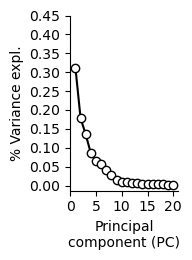

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surfplot import Plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter

FIG_DIR = os.path.join('/Users/keannarowchan/Desktop/statistical-manifolds/figures/', 'reference')
os.makedirs(FIG_DIR, exist_ok=True)

def plot_eigenvalues():
    fname = ('/Users/keannarowchan/Desktop/statistical-manifolds/data/pca-gradients-centered/reference_eigenvalues.tsv')
    eigenvals = load_table(fname)['proportion'][:20]
    k = len(eigenvals)

    fig, ax = plt.subplots( figsize=(2, 2.7))
    ax.plot(np.arange(k) + 1, eigenvals, marker='o', markerfacecolor='w', color='k')
    ax.set(ylabel='% Variance expl.', xlabel='Principal\ncomponent (PC)', xticks=np.arange(0, 21, 5), yticks=np.arange(0, .50, .05))
    
    sns.despine()
    fig.tight_layout(w_pad=3)
    return 

plot_eigenvalues()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


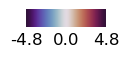

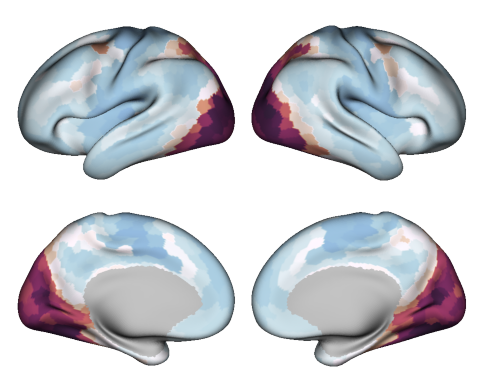

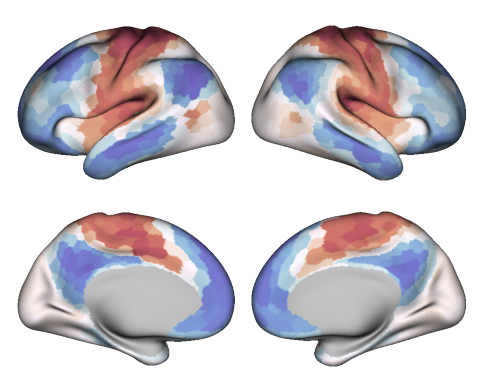

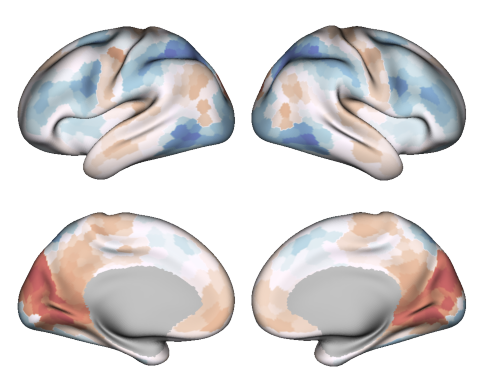

In [19]:
def show_eigenvalues():
    fname = ('/Users/keannarowchan/Desktop/statistical-manifolds/data/pca-gradients-centered/reference_eigenvalues.tsv')
    df = load_table(fname)
    df['cumulative'] = df['proportion'].cumsum()
    return df

def plot_ref_brain_gradients(k=3):
    fname = os.path.join('/Users/keannarowchan/Desktop/pulling_Server/reference_gradient.tsv')
    gradients = load_gradients(fname, k)
    prefix = os.path.join(FIG_DIR, 'gradients_')
    cmap = 'twilight_shifted'
    grads = gradients.filter(like='g').values
    vmax = np.around(grads.max(), decimals=1)
    plot_cbar(cmap, -vmax, vmax, 'horizontal', size=(1, .3), n_ticks=3)
    plt.savefig(prefix + 'cbar')      
    
    surfaces = get_surfaces()
    for i in range(k):
        x = weights_to_vertices(grads[:, i], atlas)

        p = Plot(surfaces['lh'], surfaces['rh'])
        p.add_layer(x, cmap=cmap, color_range=(-vmax, vmax), cbar=False)
        fig = p.build(colorbar=False)
        fig.savefig(prefix + f'PC{i + 1}_brain')
        
plot_ref_brain_gradients(k=3)

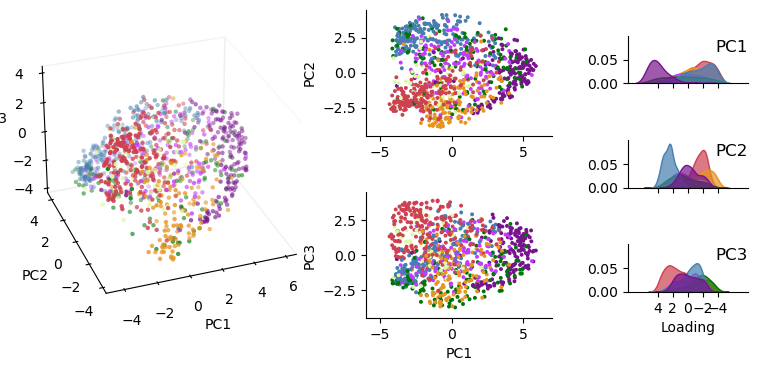

In [21]:
def plot_loading_distributions(view_3d=(30, -150)):

    fname = os.path.join('/Users/keannarowchan/Desktop/statistical-manifolds/data/pca-gradients-centered/reference_gradient.tsv')
    df = load_gradients(fname, 3)
    df = df.iloc[1: , :]
    cmap = yeo_cmap()

    df['c'] = df['network'].apply(lambda x: cmap[x])
    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(nrows=12, ncols=12) 
    # 3D scatter plot
    ax1 = fig.add_subplot(gs[:, :6], projection='3d')
    plot_3d(df['g1'], df['g2'], df['g3'], color=df['c'], ax=ax1, view_3d=view_3d, s=10, lw=0)

    # 2D views
    ax2 = fig.add_subplot(gs[:5, 6:9])
    sns.scatterplot(x='g1', y='g2', hue='network', data=df, palette=cmap, legend=False, ax=ax2, linewidths=0, s=8, edgecolor='none')
    ax2.set(xlabel='', ylabel='PC2', xlim=(-6, 7), ylim=(-4.5, 4.5))
    ax2 = fig.add_subplot(gs[7:, 6:9])
    sns.scatterplot(x='g1', y='g3', hue='network', data=df, palette=cmap, legend=False, ax=ax2, linewidths=0, s=8, edgecolor='none')
    ax2.set(xlabel='PC1', ylabel='PC3', xlim=(-6, 7), ylim=(-4.5, 4.5))

    # distribution plots
    for i, g in zip([1, 5, 9], ['g1', 'g2', 'g3']):
        ax = fig.add_subplot(gs[i:i+2, 10:])
        sns.kdeplot(x=g, hue='network', data=df, palette=cmap, shade=True, ax=ax, legend=False, alpha=.7)
            
        ax.set(xlabel='', ylim=(0, .1), yticks=(0, .05), ylabel='', xlim=(8, -8), xticks=range(-4, 5, 2))
        if g == 'g3':
            ax.set_xlabel('Loading')
        else:
            ax.set_xticklabels([])
        num = g[1]
        ax.set_title(f'PC{num}', loc='right', y=.5)
        sns.despine()
        
plot_loading_distributions(view_3d=(30, -110))

In [ ]:
def plot_eccentricity_calc(view_3d=(30, -110)):
    fname = os.path.join('/Volumes/KeannaRowchan/statistical-manifolds/statistical-manifolds/data/schaefer1000-7networks-final/pca-gradients-centered/reference_gradient.tsv')
    df = load_gradients(fname, 3)
    df = df.iloc[1: , :]
    cmap = yeo_cmap()
    df['c'] = df['network'].apply(lambda x: cmap[x])

    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(projection='3d')
    plot_3d(df['g1'], df['g2'], df['g3'], color=df['c'], ax=ax1, view_3d=view_3d, s=10, lw=0, alpha=.2)

    centroid = np.array([0, 0, 0])
    for i in [10, 212, 100, 440]:
        data = np.vstack([centroid, df.loc[i, ['g1', 'g2', 'g3']].values])
        ax1.plot(data[:, 0], data[:, 1], data[:, 2], c='k', ls='--')
        ax1.scatter([0],[0], [0], color='k', marker='s', s=30, alpha=1)
        plot_3d(data[1, 0], data[1, 1], data[1, 2], df.loc[i, 'c'], ax=ax1, alpha=1, edgecolor='k', view_3d=view_3d)
        plot_3d(data[0, 0], data[0, 1], data[0, 2], color='k', ax=ax1, alpha=1, view_3d=view_3d)
    fig.savefig(os.path.join(FIG_DIR, 'ecc_calculation'))

plot_eccentricity_calc(view_3d=(30, -100))